# CNN Implementation - Splice Constant

## Load Data

In [62]:
# Hyper Parameters
N = 48
LENGTH = 30_000 // N
LR = 0.000005
EPOCHS = 30
splits = [0.8, 0.1, 0.1]
SEED = 21
data_dir = "../data/age_decades/"

In [63]:
import os
import math
import numpy as np
import pandas as pd
from datetime import datetime

def raw_recording_to_dict(filepath, rawPythonic=True):
    
    recording = {}
    
    with open(filepath) as raw_recording:
        
        recording["Gender"] = filepath.split("/")[-1][0:1]
        recording["AgeDecade"] = filepath.split("/")[-1][1:3]
        recording["RecordingStartTime"] = datetime.strptime(filepath.split("/")[-1][4:9], '%H.%M').time()
        
        series = {"ContractionNo": [], "ContractionNoNorm": [], "RrInterval": []}
        
        first_index = None
        previous_ContractionNo = None
        
        for line in raw_recording:
            
            # Handling shifted indexes
            if first_index is None:
                first_index = int(line.split()[1])
            
            # Fill missing data with None's
            if previous_ContractionNo is not None:
                diff = abs(previous_ContractionNo - int(line.split()[1]))
                
                if diff > 1:
                    
                    filling_indexes = np.array(range(previous_ContractionNo+1, int(line.split()[1])))
                    
                    series["ContractionNo"].extend(filling_indexes)
                    series["ContractionNoNorm"].extend(filling_indexes - first_index)
                    series["RrInterval"].extend([math.nan]*(diff-1))
          
            series["ContractionNo"].append(int(line.split()[1]))
            series["ContractionNoNorm"].append(int(line.split()[1]) - first_index)
            series["RrInterval"].append(int(line.split()[0]))
            
            previous_ContractionNo = int(line.split()[1])
            
        if rawPythonic:
            recording["Series"] = series
            recording["RecordingStartTime"] = str(recording["RecordingStartTime"])
        else:
            recording["Series"] = pd.DataFrame(series)
            
        return recording

In [64]:
%%time
recordings = []
for filename in os.listdir(data_dir):
    recordings.append(raw_recording_to_dict(data_dir + filename, False))

CPU times: user 11.3 s, sys: 45.8 ms, total: 11.3 s
Wall time: 11.3 s


In [65]:
len(recordings)

181

In [66]:
recordings[0]

{'Gender': 'm',
 'AgeDecade': '50',
 'RecordingStartTime': datetime.time(10, 5),
 'Series':        ContractionNo  ContractionNoNorm  RrInterval
 0              49291                  0      1016.0
 1              49292                  1      1000.0
 2              49293                  2      1016.0
 3              49294                  3      1032.0
 4              49295                  4      1008.0
 ...              ...                ...         ...
 21797          71088              21797      1312.0
 21798          71089              21798      1328.0
 21799          71090              21799      1296.0
 21800          71091              21800      1296.0
 21801          71092              21801      1288.0
 
 [21802 rows x 3 columns]}

In [67]:
set([int(recording["AgeDecade"]) for recording in recordings])

{20, 30, 40, 50, 60, 70, 80}

In [68]:
type(recordings[0]["Series"])

pandas.core.frame.DataFrame

In [69]:
recordings[0]["Series"]

,ContractionNo,ContractionNoNorm,RrInterval
0,49291,0,1016.0
1,49292,1,1000.0
2,49293,2,1016.0
3,49294,3,1032.0
4,49295,4,1008.0
...,...,...,...
21797,71088,21797,1312.0
21798,71089,21798,1328.0
21799,71090,21799,1296.0
21800,71091,21800,1296.0


## Splicing

In [70]:
len(recordings[0]["Series"])

21802

In [71]:
recordings[0]["Series"].iloc[0:9,]

,ContractionNo,ContractionNoNorm,RrInterval
0,49291,0,1016.0
1,49292,1,1000.0
2,49293,2,1016.0
3,49294,3,1032.0
4,49295,4,1008.0
5,49296,5,1024.0
6,49297,6,1024.0
7,49298,7,1032.0
8,49299,8,1024.0


In [72]:
def splice_random(series, n=100, size=500, sigma=50):
    cap = len(series) - size
    starts = np.random.randint(cap, size=n)
    ends = [max(min(round(np.random.normal(start+size, sigma)), cap+size), start+1) for start in starts]
    splices = [series.iloc[start:end,] for start, end in zip(starts, ends)]
    return splices

In [73]:
def splice_constant(series, n=48):
    return np.array_split(series, n)

In [74]:
def splice_rr_intervals_constant(rr_intervals, n=48):
    
    spliced_recordings = []
    
    for recording in rr_intervals:
        # List of data frames
        splices = splice_constant(recording["Series"], n=n)
        
        for splice in splices:
            recording_copy = recording.copy()
            recording_copy["Series"] = splice
            spliced_recordings.append(recording_copy)
            
    return spliced_recordings  

In [75]:
def splice_rr_intervals_random(rr_intervals, n=48, size=500, sigma=50):
    
    spliced_recordings = []
    
    for recording in rr_intervals:
        # List of data frames
        splices = splice_random(recording["Series"], n=n, size=500, sigma=50)
        
        for splice in splices:
            recording_copy = recording.copy()
            recording_copy["Series"] = splice
            spliced_recordings.append(recording_copy)
            
    return spliced_recordings  

## Pre-Processing

- Interpolation
- Split into train, val, test

In [76]:
def decade_to_label(decade):
    return(int(int(decade)/10) - 2)

In [77]:
def label_to_decade(label):
    return(str((label+2)*10))

In [78]:
def pad(l, size, padding):
    l = list(l)
    l = l[0:min(len(l), size)]
    return l + [padding] * abs((len(l)-size))

In [79]:
decade_to_label("90")

7

In [80]:
label_to_decade(7)

'90'

Data must be split here.

In [81]:
%%time
train_orig, val_orig, test_orig = np.array_split(recordings, (np.array(splits)[:-1].cumsum() * len(recordings)).astype(int))
train = splice_rr_intervals_constant(train_orig, n=N)
val = splice_rr_intervals_constant(val_orig, n=N)
test = splice_rr_intervals_constant(test_orig, n=N)

CPU times: user 1.78 s, sys: 16.9 ms, total: 1.8 s
Wall time: 1.79 s


In [82]:
train[0]["Series"].shape

(455, 3)

In [83]:
train[1]["Series"].shape

(455, 3)

In [84]:
len(train)

6912

In [85]:
len(val)

864

In [86]:
len(test)

912

Splice random looks fine.

In [87]:
test_series = train_orig[0]["Series"]["RrInterval"][0:20]
res = splice_random(test_series, n=2, size=10, sigma=1)
print(res[0])
print("aaa")
print(res[1])

2     1016.0
3     1032.0
4     1008.0
5     1024.0
6     1024.0
7     1032.0
8     1024.0
9     1040.0
10    1032.0
11    1024.0
Name: RrInterval, dtype: float64
aaa
9     1040.0
10    1032.0
11    1024.0
12    1024.0
13    1024.0
14    1008.0
15    1024.0
16    1016.0
17     992.0
18    1016.0
Name: RrInterval, dtype: float64


In [88]:
max_length_rr = max([recording["Series"].shape[0] for recording in train])
colnames = ["label"] + ["rr" + str(i+1) for i in range(max_length_rr)]
print(colnames[0:5])
print(colnames[-10:])
print(list(recordings[0]["Series"]["RrInterval"])[-10:])
print(pad(recordings[0]["Series"]["RrInterval"], 21805, 0)[-10:])

['label', 'rr1', 'rr2', 'rr3', 'rr4']
['rr593', 'rr594', 'rr595', 'rr596', 'rr597', 'rr598', 'rr599', 'rr600', 'rr601', 'rr602']
[1328.0, 1336.0, 1312.0, 1336.0, 1336.0, 1312.0, 1328.0, 1296.0, 1296.0, 1288.0]
[1336.0, 1336.0, 1312.0, 1328.0, 1296.0, 1296.0, 1288.0, 0, 0, 0]


In [89]:
def rr_interval_dict_to_matrix(rr_interval_dict, pad_length):
    data = []
    labels = []
    for recording in rr_interval_dict:
        label = decade_to_label(recording["AgeDecade"])
        series = pad(recording["Series"]["RrInterval"], pad_length, 0)
        labels.append(label)
        data.append(series)
    data = pd.DataFrame(data)
    
    return labels, data

In [90]:
%%time
train_labels, train = rr_interval_dict_to_matrix(train, max_length_rr)
val_labels, val = rr_interval_dict_to_matrix(val, max_length_rr)
test_labels, test = rr_interval_dict_to_matrix(test, max_length_rr)
train

CPU times: user 2.25 s, sys: 46.6 ms, total: 2.3 s
Wall time: 2.3 s


,0,1,2,3,4,5,6,7,8,9,...,592,593,594,595,596,597,598,599,600,601
0,1016.0,1000.0,1016.0,1032.0,1008.0,1024.0,1024.0,1032.0,1024.0,1040.0,...,0,0,0,0,0,0,0,0,0,0
1,1008.0,984.0,984.0,976.0,976.0,976.0,976.0,976.0,976.0,1000.0,...,0,0,0,0,0,0,0,0,0,0
2,1016.0,1000.0,1000.0,1000.0,992.0,992.0,984.0,960.0,952.0,928.0,...,0,0,0,0,0,0,0,0,0,0
3,1064.0,1040.0,1048.0,1024.0,1024.0,1016.0,1008.0,1008.0,1000.0,1008.0,...,0,0,0,0,0,0,0,0,0,0
4,1080.0,1072.0,1080.0,1088.0,1072.0,1080.0,1064.0,1024.0,1008.0,984.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6907,1288.0,1280.0,1248.0,1232.0,1296.0,1304.0,1232.0,1224.0,1192.0,1024.0,...,0,0,0,0,0,0,0,0,0,0
6908,1216.0,1208.0,1112.0,976.0,1040.0,1072.0,864.0,784.0,736.0,696.0,...,0,0,0,0,0,0,0,0,0,0
6909,1416.0,1344.0,1256.0,1128.0,1096.0,1032.0,984.0,960.0,976.0,1000.0,...,0,0,0,0,0,0,0,0,0,0
6910,1192.0,1312.0,1264.0,1184.0,1184.0,1168.0,1152.0,1032.0,1072.0,1256.0,...,0,0,0,0,0,0,0,0,0,0


Finding Nans:

In [91]:
train.iloc[1,:]

0      1008.0
1       984.0
2       984.0
3       976.0
4       976.0
        ...  
597       0.0
598       0.0
599       0.0
600       0.0
601       0.0
Name: 1, Length: 602, dtype: float64

In [92]:
train.shape

(6912, 602)

In [93]:
val.shape

(864, 602)

In [94]:
test.shape

(912, 602)

In [95]:
%%time

series = None
indeces = None

for i in range(train.shape[0]):
    try:
        indeces = []
        for index, value in enumerate(train.iloc[i,:].tolist()):
            if np.isnan(value):
                indeces.append(index)

        series = train.iloc[i, indeces[0]-10:indeces[0]+30]
        break
    except IndexError:
        continue
series

CPU times: user 96.1 ms, sys: 0 ns, total: 96.1 ms
Wall time: 93.9 ms


422    1200.0
423    1256.0
424    1288.0
425    1312.0
426    1368.0
427    1368.0
428    1408.0
429    1456.0
430    1488.0
431    1488.0
432       NaN
433       NaN
434       NaN
435       NaN
436       NaN
437       NaN
438       NaN
439       NaN
440       NaN
441    1408.0
442    1368.0
443    1368.0
444    1328.0
445    1320.0
446    1336.0
447    1280.0
448    1328.0
449    1272.0
450    1264.0
451    1200.0
452    1200.0
453    1200.0
454       0.0
455       0.0
456       0.0
457       0.0
458       0.0
459       0.0
460       0.0
461       0.0
Name: 44, dtype: float64

In [102]:
for index in series.index:
    print(f"{index-421}, ", end = '')

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 

In [106]:
for value in series:
    print(f"{value}, ", end = '')

1200.0, 1256.0, 1288.0, 1312.0, 1368.0, 1368.0, 1408.0, 1456.0, 1488.0, 1488.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1408.0, 1368.0, 1368.0, 1328.0, 1320.0, 1336.0, 1280.0, 1328.0, 1272.0, 1264.0, 1200.0, 1200.0, 1200.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

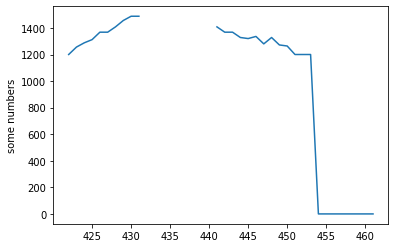

In [37]:
import matplotlib.pyplot as plt
plt.plot(series)
plt.ylabel('some numbers')
plt.show()

In [38]:
%%time
train.iloc[2,:].interpolate(method='linear'),

CPU times: user 2.63 ms, sys: 68 µs, total: 2.7 ms
Wall time: 2.43 ms


(0      1016.0
 1      1000.0
 2      1000.0
 3      1000.0
 4       992.0
         ...  
 597       0.0
 598       0.0
 599       0.0
 600       0.0
 601       0.0
 Name: 2, Length: 602, dtype: float64,)

In [39]:
%%time
train = train.interpolate(method='linear', axis=1, limit_direction='both')
val = val.interpolate(method='linear', axis=1, limit_direction='both')
test = test.interpolate(method='linear', axis=1, limit_direction='both')

CPU times: user 410 ms, sys: 32 ms, total: 442 ms
Wall time: 440 ms


In [40]:
iseries = train.iloc[i, indeces[0]-10:indeces[0]+30]
iseries

422    1200.0
423    1256.0
424    1288.0
425    1312.0
426    1368.0
427    1368.0
428    1408.0
429    1456.0
430    1488.0
431    1488.0
432    1480.0
433    1472.0
434    1464.0
435    1456.0
436    1448.0
437    1440.0
438    1432.0
439    1424.0
440    1416.0
441    1408.0
442    1368.0
443    1368.0
444    1328.0
445    1320.0
446    1336.0
447    1280.0
448    1328.0
449    1272.0
450    1264.0
451    1200.0
452    1200.0
453    1200.0
454       0.0
455       0.0
456       0.0
457       0.0
458       0.0
459       0.0
460       0.0
461       0.0
Name: 44, dtype: float64

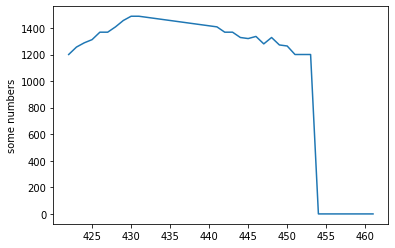

In [41]:
plt.plot(iseries)
plt.ylabel('some numbers')
plt.show()

In [42]:
train.isnull().values

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [43]:
pd.isnull(train).any(1).nonzero()[0]

<ipython-input-43-1ed16ecb9225>:1: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  pd.isnull(train).any(1).nonzero()[0]


array([], dtype=int64)

In [44]:
train.insert(0, "label", train_labels)
train.columns = colnames
train = train.astype('int32')

val.insert(0, "label", val_labels)
val.columns = colnames
val = val.astype('int32')

test.insert(0, "label", test_labels)
test.columns = colnames
test = test.astype('int32')

To prevent information leakage, we will assume that the max length is given by the training set. If an entry in tee test set it longer, we will simply drop the columns for now.

In [45]:
train.shape #6912

(6912, 603)

In [46]:
val.shape

(864, 603)

In [47]:
test.shape

(912, 603)

In [48]:
%%time
save_path_train = "{}/preprocessed/train_spliced_constant.csv".format("/".join(data_dir.split("/")[:-2]))
save_path_val = "{}/preprocessed/val_spliced_constant.csv".format("/".join(data_dir.split("/")[:-2]))
save_path_test = "{}/preprocessed/test_spliced_constant.csv".format("/".join(data_dir.split("/")[:-2]))
train.to_csv(save_path_train)
val.to_csv(save_path_val)
test.to_csv(save_path_test)

CPU times: user 4.84 s, sys: 35.9 ms, total: 4.87 s
Wall time: 4.87 s


## RrIntervalDataset

In [31]:
# Hyper Parameters
N = 48
LENGTH = 30_000 // N
LR = 0.000005
EPOCHS = 30
splits = [0.8, 0.1, 0.1]
SEED = 21
data_dir = "../data/age_decades/"

In [32]:
save_path_train = "{}/preprocessed/train_spliced_constant.csv".format("/".join(data_dir.split("/")[:-2]))
save_path_val = "{}/preprocessed/val_spliced_constant.csv".format("/".join(data_dir.split("/")[:-2]))
save_path_test = "{}/preprocessed/test_spliced_constant.csv".format("/".join(data_dir.split("/")[:-2]))

In [33]:
from torch.utils.data import Dataset
import os

class RrIntervalDataset(Dataset):
    def __init__(self, path, header=True):
        
        self.samples = []
        
        with open(path, 'r') as file:
            if header:
                next(file)
            for line in file:
                self.samples.append(list(map(lambda x: int(x), line.split(",")[1:])))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]

In [34]:
train_data = RrIntervalDataset(save_path_train)
val_data = RrIntervalDataset(save_path_val)
test_data = RrIntervalDataset(save_path_test)

In [35]:
aaa = iter(train_data)
print(next(aaa)[:10])

[3, 1016, 1000, 1016, 1032, 1008, 1024, 1024, 1032, 1024]


## RrIntervalDataLoader

In [36]:
import torch
def __batch2tensor__(batch):
    """
    Takes a batch and transforms it in such a way that it can directly be fed to the network.
    @param batch: List of x and y labels.
    @return: Two tensors, one for x and one for y.
    """
    #print(batch)
    x, y = [None] * len(batch), [None] * len(batch)
    for i, row in enumerate(batch):
        #print(row)
        y[i] = row[0]
        x[i] = row[1:]

    return torch.FloatTensor(x), torch.LongTensor(y)

In [37]:
from torch.utils.data import DataLoader

rrIntervalDataLoaderTrain = DataLoader(train_data, batch_size=N, num_workers=4, collate_fn=__batch2tensor__)#, shuffle=True)
rrIntervalDataLoaderVal = DataLoader(val_data, batch_size=N, num_workers=4, collate_fn=__batch2tensor__)
rrIntervalDataLoaderTest = DataLoader(test_data, batch_size=N, num_workers=4, collate_fn=__batch2tensor__)

## Model

Input: $N, C_{in}, L_{in}$

Output: $N, C_{out} , L_{out}$

where $N$ is a batch size, $C$ denotes a number of channels, $L$ is a length of signal sequence.

In [38]:
import torch.nn as nn
# IN: N, C, L
input = torch.randn(2, 16, 50)
input.shape

torch.Size([2, 16, 50])

In [39]:
input

tensor([[[-9.7762e-02,  1.3909e+00,  1.4261e+00,  ...,  1.2008e+00,
           1.0296e+00, -6.7870e-01],
         [ 3.3386e-01,  6.0472e-02,  1.0088e+00,  ...,  1.5575e+00,
           7.4824e-02,  3.0662e-01],
         [ 7.7931e-01,  1.5868e-01, -2.4308e+00,  ..., -5.3571e-01,
          -1.0052e+00,  1.2988e+00],
         ...,
         [ 1.6651e-01,  4.9618e-01,  1.2523e-01,  ..., -1.3838e+00,
           1.3517e+00,  1.7967e+00],
         [-9.2586e-01,  5.0550e-01,  1.4499e+00,  ...,  6.2243e-02,
          -1.7496e+00, -1.3120e+00],
         [-5.8477e-01,  3.2914e-01,  6.1246e-01,  ..., -3.3212e-01,
          -2.6463e-01,  1.3672e+00]],

        [[-9.4175e-01, -2.7243e-01,  1.7003e+00,  ..., -9.0247e-01,
          -1.4418e-01,  1.0229e+00],
         [-1.8029e+00, -5.2971e-01, -1.7690e-01,  ..., -6.3490e-01,
          -2.1641e-01,  6.6434e-01],
         [-3.2665e-01, -1.1407e+00, -2.1364e+00,  ..., -3.7130e-01,
          -3.7706e-01, -6.1842e-01],
         ...,
         [ 1.0825e+00, -1

In [40]:
#in_channels, out_channels, kernel_size
m = nn.Conv1d(16, 33, 3, stride=2)
output = m(input)
output.shape

torch.Size([2, 33, 24])

In [41]:
# target output size of 5
m = nn.AdaptiveMaxPool1d(5)
input = torch.randn(1, 64, 8)
output = m(input)

In [42]:
output.shape

torch.Size([1, 64, 5])

In [43]:
import torch.nn as nn

class CnnStage(nn.Module):
    def __init__(self, avg_sequence_length=25_000, dropout=0.25, no_classes=7):
        super().__init__()

        # Dropout
        # Maybe for CNN, check literature
        self.dropout = nn.Dropout(p=dropout)
        
        # Convolutions
        #in_channels, out_channels, kernel_size
        self.conv1d1 = nn.Conv1d(1, 64, 3, stride=1)
        self.conv1d2 = nn.Conv1d(64, 64, 3, stride=1)
        
        self.conv1d3 = nn.Conv1d(64, 128, 3, stride=1)
        self.conv1d4 = nn.Conv1d(128, 128, 3, stride=1)
        
        # Forward // Don't how to _not_ hardcode this...
        self.fc1 = nn.Linear(2432, 256)
        self.fc2 = nn.Linear(256, no_classes)
        
        # Activation
        self.relu = nn.ReLU()

        # Pooling
        ## MaxPool
        self.maxpool = nn.AdaptiveMaxPool1d(avg_sequence_length//10)
        ## Average
        self.avgpool = torch.nn.AvgPool1d(3)
        
        # Softmax
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        
        # CNN
        x = x.view(x.shape[0], -1, x.shape[1])
        x = self.conv1d1(x)
        x = self.relu(x)
        x = self.conv1d2(x)
        x = self.maxpool(x)
        x = self.conv1d3(x)
        x = self.relu(x)
        x = self.conv1d4(x)
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        
        # FFN
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.softmax(x)
        
        return x
    
model = CnnStage(LENGTH).cuda()
X, Y = next(iter(rrIntervalDataLoaderTrain))
X

tensor([[1016., 1000., 1016.,  ...,    0.,    0.,    0.],
        [1008.,  984.,  984.,  ...,    0.,    0.,    0.],
        [1016., 1000., 1000.,  ...,    0.,    0.,    0.],
        ...,
        [1208., 1256., 1280.,  ...,    0.,    0.,    0.],
        [1336., 1320., 1320.,  ...,    0.,    0.,    0.],
        [1344., 1320., 1336.,  ...,    0.,    0.,    0.]])

In [44]:
model(X.cuda()).shape[0]

48

## Training

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = torch.nn.NLLLoss()
epochs = EPOCHS

In [46]:
training_loss_storage = []
training_accuracy_storage = []
validation_loss_storage = []
validation_accuracy_storage = []

for i in range(epochs):
    
    print("Epoch: {}".format(i+1))
    
    training_loss = 0
    training_accuracy = 0
    training_processed_data = 0
    
    for x, y in rrIntervalDataLoaderTrain:
        x = x.cuda()
        y = y.cuda()
        
        #print(x)
        #print(y)
        
        # Reset Gradients
        optimizer.zero_grad()

        # Forward, Loss, Backwards, Update
        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
        training_processed_data += x.shape[0]

        # Calculate Metrics
        training_loss += loss.item()
        training_accuracy += torch.sum(torch.exp(output).topk(1)[1].view(-1) == y).item()
    
    else:
        print("Training Loss: {}".format(training_loss/training_processed_data))
        print("Training Accuracy: {}".format(training_accuracy/training_processed_data))
        
        training_loss_storage.append(training_loss/training_processed_data)
        training_accuracy_storage.append(training_accuracy/training_processed_data)
        
        validation_loss = 0
        validation_accuracy = 0
        validation_processed_data = 0

        model.eval()

        with torch.no_grad():
            for x, y in rrIntervalDataLoaderVal:
                x = x.cuda()
                y = y.cuda()

                output_validation = model(x)
                loss_val = criterion(output_validation, y)
                
                validation_processed_data += x.shape[0]
                
                validation_loss += loss_val.item()
                validation_accuracy += torch.sum(
                    torch.exp(output_validation).topk(1, dim=1)[1].view(-1) == y).item()
            else:
                print("Validation Loss: {}".format(validation_loss/validation_processed_data))
                print("Validation Accuracy: {}".format(validation_accuracy/validation_processed_data))
                
                validation_loss_storage.append(validation_loss/validation_processed_data)
                validation_accuracy_storage.append(validation_accuracy/validation_processed_data)
                
                model.train()
                

Epoch: 1
Training Loss: 0.6456149441224558
Training Accuracy: 0.1283275462962963
Validation Loss: 0.12343341746815929
Validation Accuracy: 0.07291666666666667
Epoch: 2
Training Loss: 0.4921411357268139
Training Accuracy: 0.14091435185185186
Validation Loss: 0.095349939815976
Validation Accuracy: 0.16550925925925927
Epoch: 3
Training Loss: 0.4161363340638302
Training Accuracy: 0.13816550925925927
Validation Loss: 0.0935154667262126
Validation Accuracy: 0.1111111111111111
Epoch: 4
Training Loss: 0.35405112289030244
Training Accuracy: 0.14930555555555555
Validation Loss: 0.08359081060108212
Validation Accuracy: 0.1886574074074074
Epoch: 5
Training Loss: 0.3119094534604638
Training Accuracy: 0.15031828703703703
Validation Loss: 0.07415476613850505
Validation Accuracy: 0.26273148148148145
Epoch: 6
Training Loss: 0.264133482809282
Training Accuracy: 0.16247106481481483
Validation Loss: 0.07325562562241598
Validation Accuracy: 0.23958333333333334
Epoch: 7
Training Loss: 0.22804806450450862
Tr

True label:

In [47]:
X, Y = next(iter(rrIntervalDataLoaderVal))
res = model(X.cuda()).cpu()

In [48]:
true_label = int(Y[0])

In [49]:
import numpy as np
import matplotlib.pyplot as plt

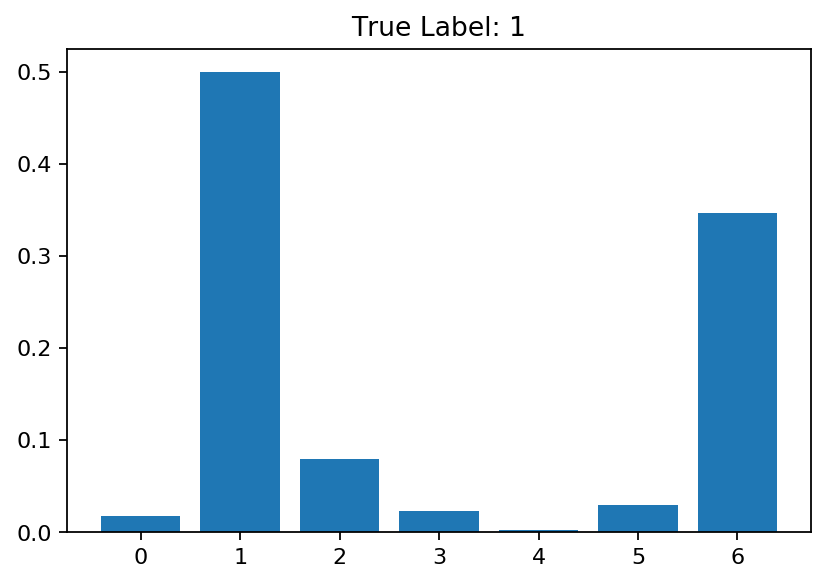

In [50]:
posterior = np.array(torch.exp(res[0]).detach().cpu())
plt.bar(range(7), posterior);
plt.title(f'True Label: {true_label}');

In [51]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi']= 160

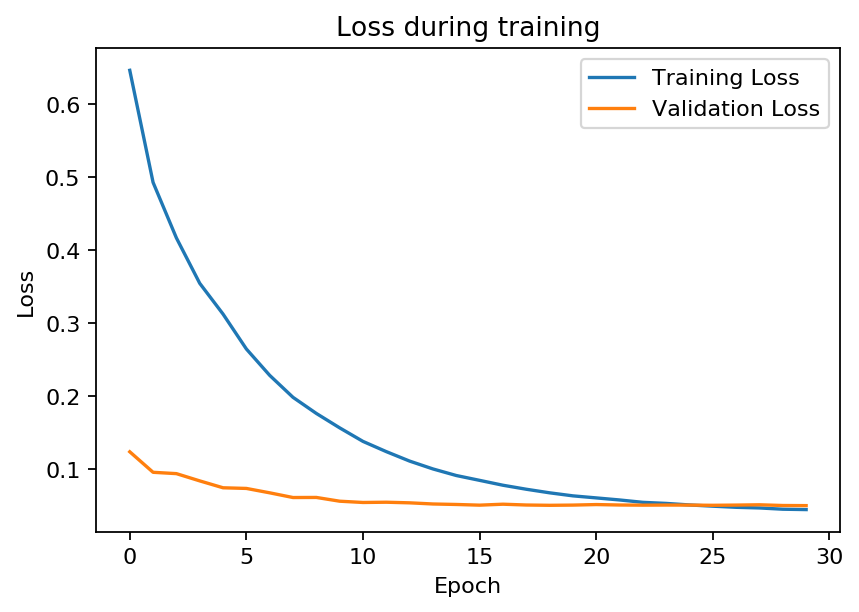

In [52]:
plt.plot(range(len(training_loss_storage)), training_loss_storage, label="Training Loss");
plt.plot(range(len(validation_loss_storage)), validation_loss_storage, label="Validation Loss");
plt.legend()
plt.ylabel('Loss');
plt.xlabel('Epoch');
plt.title('Loss during training');

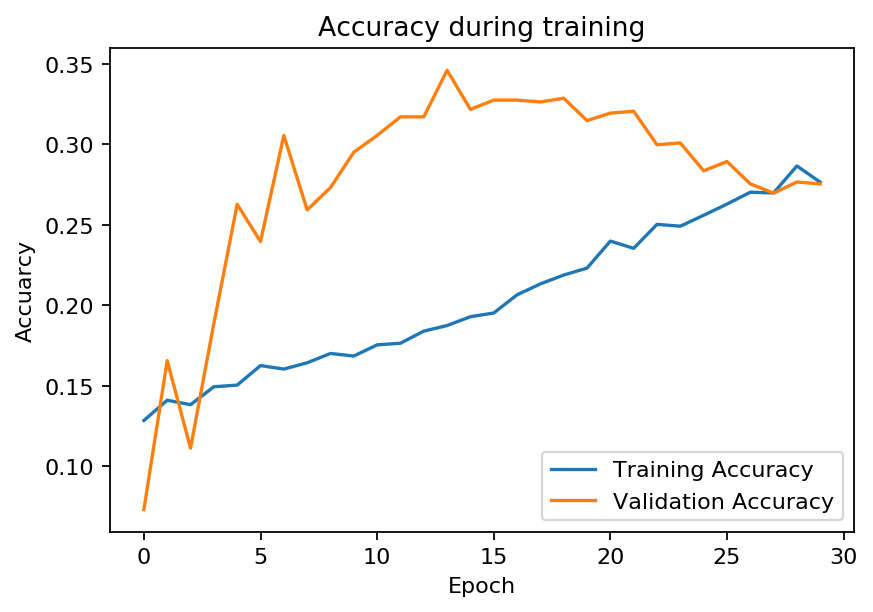

In [53]:
plt.plot(range(len(training_accuracy_storage)), training_accuracy_storage, label="Training Accuracy");
plt.plot(range(len(validation_accuracy_storage)), validation_accuracy_storage, label="Validation Accuracy");
plt.legend()
plt.ylabel('Accuarcy');
plt.xlabel('Epoch');
plt.title('Accuracy during training');

## Testing

**This code only works if the data sets are not shuffled!!!**

In [54]:
def distrib(predictions, classes=7):
    res = [0]*classes
    
    for pred in predictions:
        res[pred] += 1
    return res

In [55]:
def classify_with_probs(dataLoader):
    
    matches = []
    model.eval()
    
    for x, y in dataLoader:
        
        y_hat = model(x.cuda()).cpu()
        y_hat = np.array(torch.exp(y_hat).detach().numpy())
        y_hat = np.argmax(np.sum(y_hat, axis=0))
        matches.append(np.argmax(y_hat) == np.array(y[0]))
        
    model.train()
    
    return matches

In [56]:
def classify(dataLoader):
    
    matches = []
    model.eval()
    
    for x, y in dataLoader:

        y_hat = model(x.cuda()).cpu()
        y_hat = distrib(np.array(torch.exp(y_hat).topk(1, dim=1)[1].view(-1)))
        matches.append(np.argmax(y_hat) == y[0])
  
    model.train()
    
    return matches

In [57]:
np.mean(classify(rrIntervalDataLoaderVal))

0.3333333333333333

In [58]:
np.mean(classify_with_probs(rrIntervalDataLoaderVal))

0.16666666666666666

In [59]:
np.mean(classify(rrIntervalDataLoaderTest))

0.05263157894736842

In [60]:
np.mean(classify_with_probs(rrIntervalDataLoaderTest))

0.15789473684210525